### Setup

In [1]:
import lib
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

l = lib.Offload()

### Lässt sich anhand der Luftqualität etwas über die Anzahl Personen im Raum aussagen?

#### With People counter

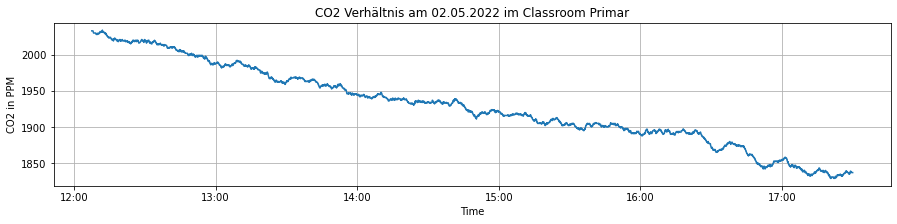

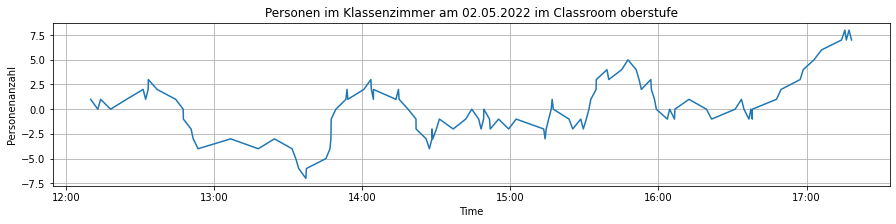

           id      id  fk_classroom_id             id          co2  \
count  3790.0  3790.0           3790.0    3790.000000  3789.000000   
mean      2.0     2.0              2.0  979106.054090  1928.174452   
std       0.0     0.0              0.0    3282.738828    54.063237   
min       2.0     2.0              2.0  973424.000000  1829.000000   
25%       2.0     2.0              2.0  976264.750000  1893.000000   
50%       2.0     2.0              2.0  979105.500000  1922.000000   
75%       2.0     2.0              2.0  981948.250000  1967.000000   
max       2.0     2.0              2.0  984791.000000  2034.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  3789.000000  3789.000000                     3790.0   3789.000000  
mean     24.415775    45.650491                        2.0  40329.045131  
std       0.604358     0.545692                        0.0     66.143147  
min      23.380000    44.660000                        2.0  40112.000

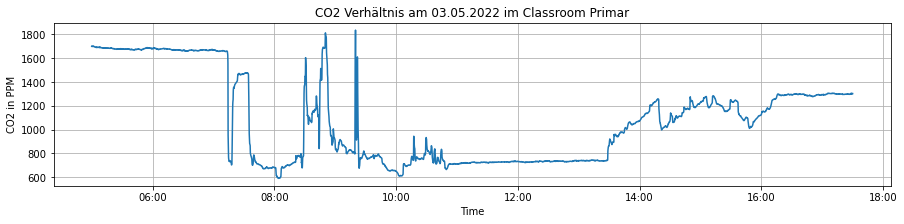

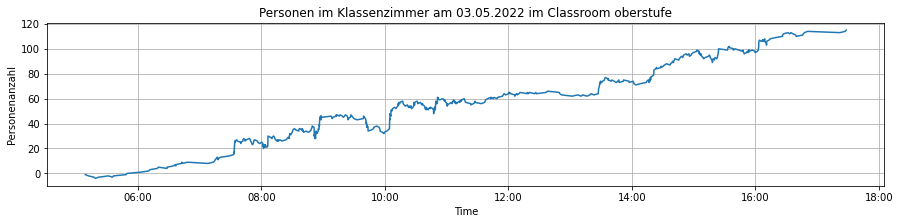

           id      id  fk_classroom_id            id          co2  \
count  8795.0  8795.0           8795.0  8.795000e+03  8788.000000   
mean      2.0     2.0              2.0  1.014279e+06  1086.413291   
std       0.0     0.0              0.0  7.110712e+03   360.547976   
min       2.0     2.0              2.0  1.003282e+06   591.000000   
25%       2.0     2.0              2.0  1.007682e+06   735.000000   
50%       2.0     2.0              2.0  1.013910e+06  1065.000000   
75%       2.0     2.0              2.0  1.020500e+06  1298.000000   
max       2.0     2.0              2.0  1.027095e+06  1836.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8789.000000  8789.000000                     8795.0   8792.000000  
mean     23.443228    44.195764                        2.0  36013.732484  
std       2.498483     4.925492                        0.0  11658.953629  
min      15.520000    38.710000                        2.0    688.000000  
25%

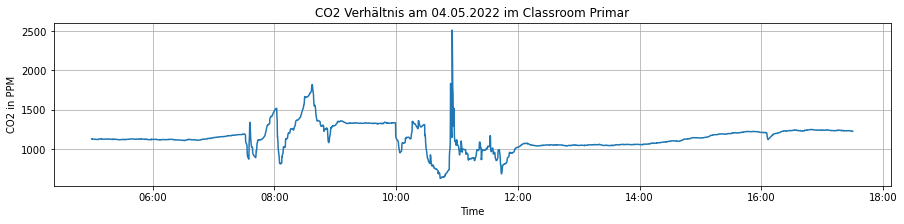

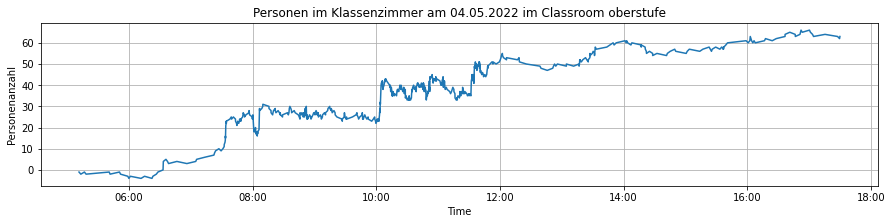

           id      id  fk_classroom_id            id          co2  \
count  8826.0  8826.0           8826.0  8.826000e+03  8818.000000   
mean      2.0     2.0              2.0  1.064711e+06  1143.597414   
std       0.0     0.0              0.0  7.649316e+03   156.977308   
min       2.0     2.0              2.0  1.051467e+06   628.000000   
25%       2.0     2.0              2.0  1.058088e+06  1057.000000   
50%       2.0     2.0              2.0  1.064712e+06  1127.000000   
75%       2.0     2.0              2.0  1.071335e+06  1233.000000   
max       2.0     2.0              2.0  1.077957e+06  2513.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8820.000000  8819.000000                     8826.0   8817.000000  
mean     24.456984    44.253282                        2.0  35824.665986  
std       1.098643     1.470729                        0.0  12145.153038  
min      22.200000    41.260000                        2.0    880.000000  
25%

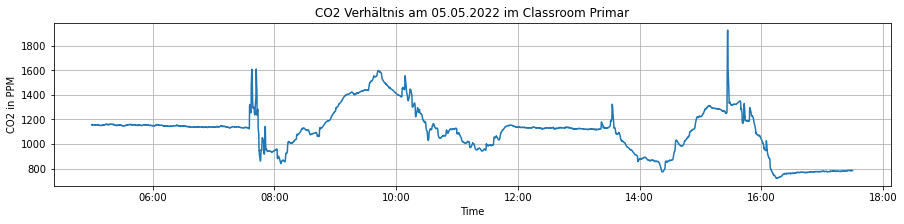

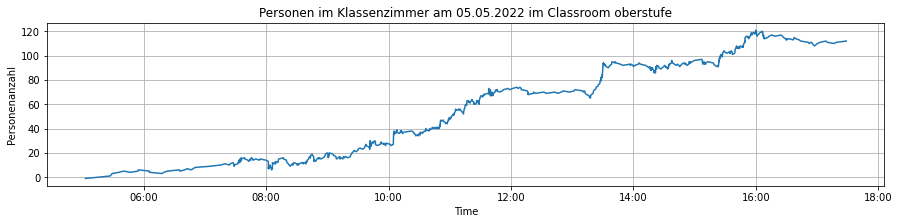

           id      id  fk_classroom_id            id          co2  \
count  8830.0  8830.0           8830.0  8.830000e+03  8825.000000   
mean      2.0     2.0              2.0  1.114245e+06  1102.520907   
std       0.0     0.0              0.0  7.649240e+03   186.942079   
min       2.0     2.0              2.0  1.101003e+06   720.000000   
25%       2.0     2.0              2.0  1.107621e+06   995.000000   
50%       2.0     2.0              2.0  1.114242e+06  1131.000000   
75%       2.0     2.0              2.0  1.120868e+06  1156.000000   
max       2.0     2.0              2.0  1.127496e+06  1925.000000   

       temperature     humidity  fk_measurement_station_id         light  
count  8823.000000  8825.000000                     8830.0   8818.000000  
mean     23.731638    48.742916                        2.0  34449.876162  
std       0.716032     1.021649                        0.0  13281.770478  
min      22.090000    47.020000                        2.0    880.000000  
25%

In [2]:
## Week 1 Korrelation People to Co2

df_people = l.get_people_count_overtime(l.get_entrance('Primarklasse_EG', startDate = "2022-05-02 05:00:00", endDate = "2022-05-02 17:30:00"))
data = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-02 05:00:00", endDate = "2022-05-02 17:30:00")

plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 02.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 02.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')


df_people = l.get_people_count_overtime(l.get_entrance('Primarklasse_EG', startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00"))
data = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-03 05:00:00", endDate = "2022-05-03 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 03.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

df_people = l.get_people_count_overtime(l.get_entrance('Primarklasse_EG', startDate = "2022-05-04 05:00:00", endDate = "2022-05-04 17:30:00"))
data = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-04 05:00:00", endDate = "2022-05-04 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 04.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

df_people = l.get_people_count_overtime(l.get_entrance('Primarklasse_EG', startDate = "2022-05-05 05:00:00", endDate = "2022-05-05 17:30:00"))
data = l.get_measurement(name = "Primarklasse_EG", startDate = "2022-05-05 05:00:00", endDate = "2022-05-05 17:30:00")


plt.figure(figsize = (15,3))
plt.plot(data["time"], data["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 05.05.2022 im Classroom Primar")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()


plt.figure(figsize = (15,3))
plt.plot(df_people["time"], df_people["people_count"])
plt.xlabel("Time")
plt.ylabel("Personenanzahl")
plt.title("Personen im Klassenzimmer am 05.05.2022 im Classroom oberstufe")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

print(data.describe())
print(f'Korrelation:{data.corrwith(df_people.people_count).co2}')

#### Mit Studenplan Personen zählen und Klassenliste

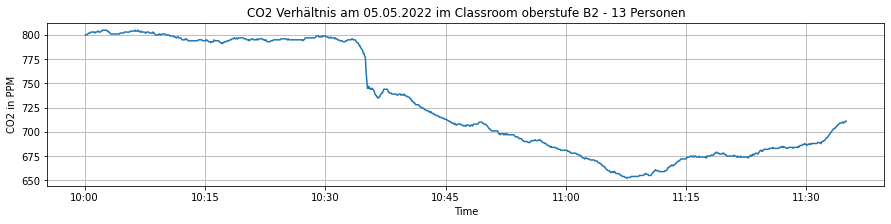

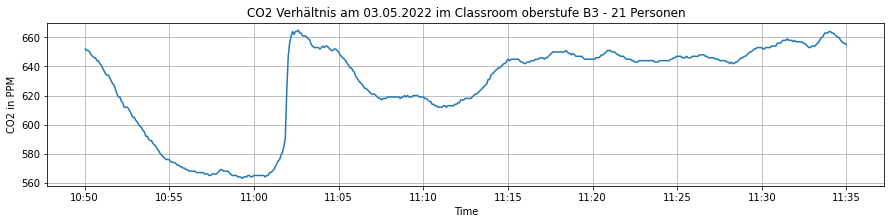

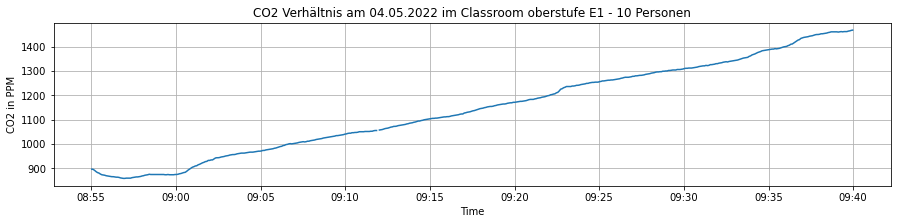

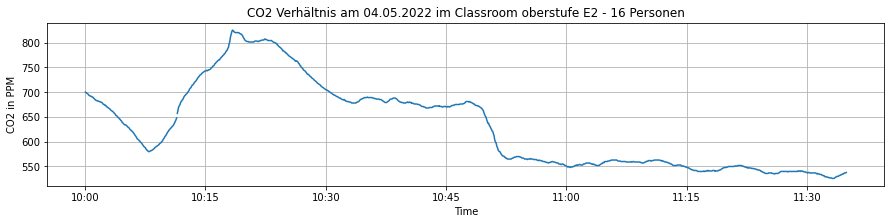

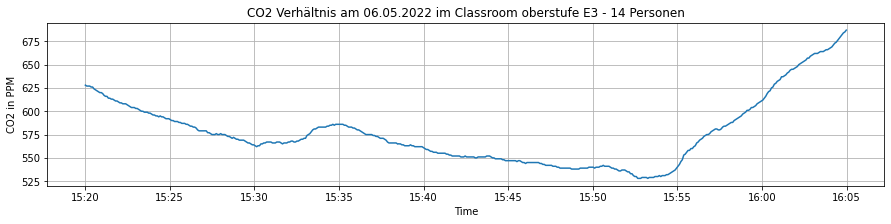

In [3]:
# Auswertung Oberstufe

# Missing Data at the moment : B1 = get_measurement(name = "oberstufe", startDate = "2022-05-02 10:00:00", endDate = "2022-05-02 11:35:00")

B2 = l.get_measurement(name = "oberstufe", startDate = "2022-05-05 10:00:00", endDate = "2022-05-05 11:35:00")


plt.figure(figsize = (15,3))
plt.plot(B2["time"], B2["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 05.05.2022 im Classroom oberstufe B2 - 13 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

B3 = l.get_measurement(name = "oberstufe", startDate = "2022-05-03 10:50:00", endDate = "2022-05-03 11:35:00")

plt.figure(figsize = (15,3))
plt.plot(B3["time"], B3["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 03.05.2022 im Classroom oberstufe B3 - 21 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E1 = l.get_measurement(name = "oberstufe", startDate = "2022-05-04 8:55:00", endDate = "2022-05-04 9:40:00")

plt.figure(figsize = (15,3))
plt.plot(E1["time"], E1["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom oberstufe E1 - 10 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E2 = l.get_measurement(name = "oberstufe", startDate = "2022-05-04 10:00:00", endDate = "2022-05-04 11:35:00")

plt.figure(figsize = (15,3))
plt.plot(E2["time"], E2["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 04.05.2022 im Classroom oberstufe E2 - 16 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()

E3 = l.get_measurement(name = "oberstufe", startDate = "2022-05-06 15:20:00", endDate = "2022-05-06 16:05:00")

plt.figure(figsize = (15,3))
plt.plot(E3["time"], E3["co2"])
plt.xlabel("Time")
plt.ylabel("CO2 in PPM")
plt.title("CO2 Verhältnis am 06.05.2022 im Classroom oberstufe E3 - 14 Personen")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid()
plt.show()
